# Proyecto 2

En esta segunda etapa del proyecto se va a utilizar modelos avanzados y diferentes transforaciones de datos para poder mejorar el desempeño y resultado del modelo anterior.

#### Librerias necesarias

In [2]:
#Importo las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#metricas
import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#modelos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#encoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputacion de valores faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Gridsearch
from sklearn.model_selection import GridSearchCV

#standar scaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
#Defino funcion para trabajar el IQR
def calcular_iqr(col,df):
    q1 = np.nanpercentile(df[col],25)
    q3 = np.nanpercentile(df[col],75)
    
    iqr = q3 - q1
    
    outlier_menor = q1 - ( iqr * 1.5 )
    outlier_mayor = q3 + ( iqr * 1.5 )
    
    mask = np.logical_and(df[col] > outlier_menor, df[col] < outlier_mayor)
    return (df[mask])

In [4]:
#Carga el dataframe
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

### Detección de valores atipicos y tratamiento de datos faltantes

In [5]:
#Filtro el dataframe por las condiciones dadas

nuevadata = data[(data['l2'] == 'Capital Federal') &
                 ((data['property_type'] == 'Departamento') |
                  (data['property_type'] == 'Casa') |
                  (data['property_type'] == 'PH')) &
                 (data['surface_covered'] <= data['surface_total']) &
                 (data['price']<=4000000)]


In [6]:
#Creo nuevo dataframe en base a las nuevas instancias
nuevadata = pd.DataFrame(nuevadata)
nuevadata = nuevadata[['l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','price','property_type']]
nuevadata

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH
...,...,...,...,...,...,...,...,...
146554,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,PH
146556,Palermo,4.0,2.0,2.0,317.0,143.0,530000.0,PH
146557,Palermo,3.0,2.0,2.0,145.0,145.0,420000.0,Departamento


#### Detección de valores atípicos

In [7]:
#Cantidad de valores faltantes por columna antes de limpiar los outliers
nuevadata.isna().sum()

l3                   0
rooms                0
bedrooms             0
bathrooms          833
surface_total        0
surface_covered      0
price                0
property_type        0
dtype: int64

In [8]:
columnas_iqr = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']
tipos_propiedad = nuevadata['property_type'].unique()
barrios = nuevadata['l3'].unique()

In [9]:
#Defino funcion para calcular el IQR
def limpiez_iqr(col):
    col=col
    sorted(col)
    q1,q3 = np.percentile(col,[25,75])
    
    iqr = q3 - q1
    
    outlier_menor = q1 - ( iqr * 1.5 )
    outlier_mayor = q3 + ( iqr * 1.5 )
    return (outlier_menor,outlier_mayor)

def graf_outliers(col,tipo,ax):
    if(tipo == 'Departamento'):
        color== 'red'
    elif(tipo == 'Casa'):
        color== 'green'
    if(tipo == 'PH'):
        color== 'blue'
    sns.boxenplot(data = nuevadata[nuevadata.property_type == tipo], x = "property_type", y = col, color=color, ax=ax)

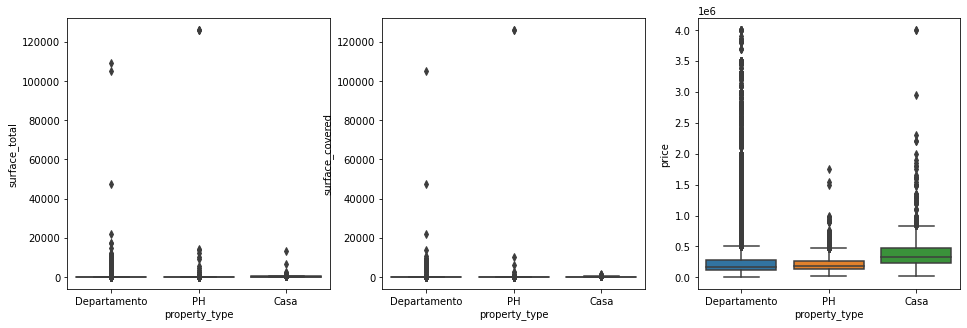

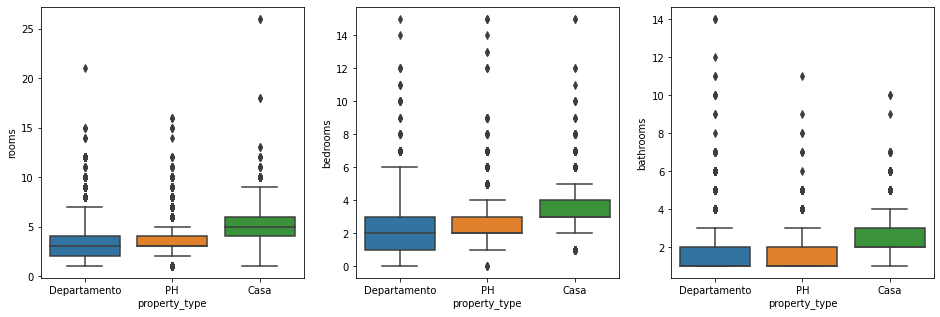

In [10]:
#grafico outliers

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "surface_total", orient="v",ax=ax1)
sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "surface_covered", orient="v",ax=ax2)
sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "price", orient="v",ax=ax3)
plt.show()

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "rooms", orient="v",ax=ax1)
sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "bedrooms", orient="v",ax=ax2)
sns.boxplot(data = nuevadata[nuevadata.rooms>0], x = "property_type", y = "bathrooms", orient="v",ax=ax3)
plt.show()



#### Manejo de datos faltantes

In [11]:
#limpieza de outliers por nan

for columna in columnas_iqr:
    for tipo in tipos_propiedad:
        data = nuevadata[(nuevadata.property_type==tipo) & nuevadata[columna] > 0][columna]
        outlier_menor,outlier_mayor = limpiez_iqr(data)
        
        if (columna=='price'):
            nuevadata.loc[(nuevadata[columna] < 0) & (nuevadata.property_type==tipo),columna] = outlier_menor
            nuevadata.loc[(nuevadata[columna] > outlier_mayor) & (nuevadata.property_type==tipo),columna] = outlier_mayor
        else:
            nuevadata.loc[(nuevadata[columna] < 0) & (nuevadata.property_type==tipo),columna] = np.nan
            nuevadata.loc[(nuevadata[columna] > outlier_mayor) & (nuevadata.property_type==tipo),columna] = np.nan

print(nuevadata.isna().sum())


l3                    0
rooms              1001
bedrooms            648
bathrooms          3537
surface_total      6060
surface_covered    5497
price                 0
property_type         0
dtype: int64


In [12]:
nuevadata = nuevadata[nuevadata.isnull().sum(axis = 1) < 3]
nuevadata.shape

(79242, 8)

## Encoding

In [13]:
#ENCODING

df_encoded = nuevadata.copy()
le = LabelEncoder()
df_encoded['property_type_encoded'] = le.fit_transform(df_encoded['property_type'])
df_encoded['l3_encoded'] = le.fit_transform(df_encoded['l3'])

df_encoded.l3_encoded = df_encoded.l3_encoded.astype('category')
df_encoded.property_type_encoded = df_encoded.property_type_encoded.astype('category')

In [14]:
df_encoded.head()
#df_encoded.isna().sum()

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,property_type_encoded,l3_encoded
0,San Cristobal,7.0,NaN,2.0,140.0,140.0,153000.0,Departamento,1,38
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,2,8
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,2,26
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,2,26
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,2,44


### Imputacion de valores faltantes

In [15]:
#imputacion de valores faltantes
#x = df_encoded[['rooms','bathrooms','bedrooms','surface_total','surface_covered','property_type_encoded','l3_encoded']]
x = df_encoded.copy().drop(['price','l3','property_type'],axis=1)
x

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_encoded,l3_encoded
0,7.0,NaN,2.0,140.0,140.0,1,38
1,2.0,1.0,2.0,70.0,58.0,2,8
2,2.0,1.0,1.0,45.0,45.0,2,26
3,2.0,1.0,1.0,85.0,50.0,2,26
5,2.0,1.0,1.0,56.0,56.0,2,44
...,...,...,...,...,...,...,...
146553,4.0,3.0,2.0,106.0,100.0,1,26
146554,4.0,3.0,3.0,175.0,111.0,2,26
146555,3.0,2.0,2.0,144.0,134.0,2,26
146556,4.0,2.0,2.0,NaN,143.0,2,26


In [16]:
sestimators = DecisionTreeRegressor(max_features='sqrt', random_state=0)

#score_interative_imputer = pd.DataFrame()
imp = IterativeImputer(random_state=30, estimator = sestimators)
x.iloc[:,:] = imp.fit_transform(x)

D:\Anaconda\envs\data_science\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [17]:
#reasigno valores
df_encoded['rooms'] = x['rooms'].values
df_encoded['bedrooms'] = x['bedrooms'].values
df_encoded['bathrooms'] = x['bathrooms'].values
df_encoded['surface_covered'] = x['surface_covered'].values
df_encoded['surface_total'] = x['surface_total'].values


In [18]:
df_encoded[df_encoded['surface_covered']>df_encoded['surface_total']]

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,property_type_encoded,l3_encoded
999,Palermo,4.0,2.0,3.0,127.0,128.000000,507500.0,Departamento,1,26
5421,Chacarita,4.0,2.0,3.0,145.0,148.000000,496000.0,Departamento,1,12
9174,Palermo,4.0,2.0,2.0,106.0,107.000000,507500.0,Departamento,1,26
9920,Recoleta,1.0,1.0,1.0,143.5,151.000000,507500.0,Departamento,1,35
9922,Recoleta,1.0,1.0,1.0,143.5,151.000000,507500.0,Departamento,1,35
...,...,...,...,...,...,...,...,...,...,...
141547,Recoleta,1.0,1.0,1.0,143.5,151.000000,507500.0,Departamento,1,35
141743,Floresta,4.0,3.0,2.0,122.0,124.000000,300000.0,Departamento,1,18
141803,Abasto,6.0,3.0,2.0,72.0,72.666667,350000.0,Departamento,1,0
141969,Retiro,5.0,3.0,2.0,124.0,124.500000,507500.0,Departamento,1,36


In [19]:
df_encoded.bathrooms = df_encoded.bathrooms.round()

In [20]:
print(df_encoded.isna().sum())

l3                       0
rooms                    0
bedrooms                 0
bathrooms                0
surface_total            0
surface_covered          0
price                    0
property_type            0
property_type_encoded    0
l3_encoded               0
dtype: int64


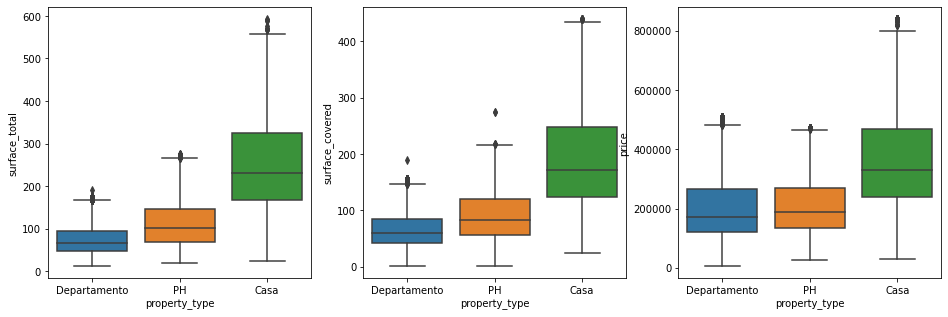

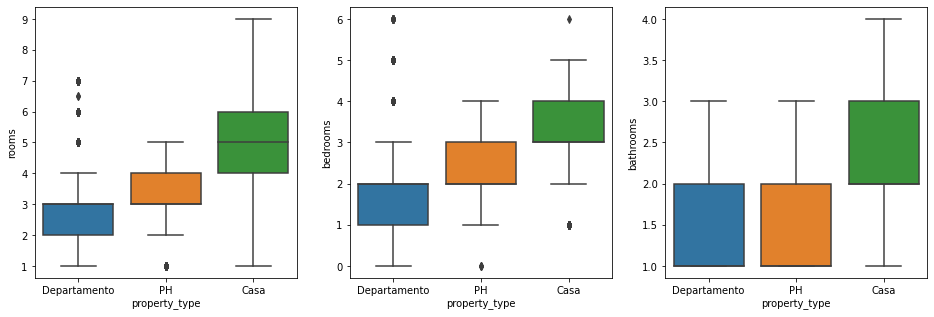

In [21]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "surface_total", orient="v",ax=ax1)
sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "surface_covered", orient="v",ax=ax2)
sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "price", orient="v",ax=ax3)
plt.show()

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "rooms", orient="v",ax=ax1)
sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "bedrooms", orient="v",ax=ax2)
sns.boxplot(data = df_encoded[df_encoded.rooms>0], x = "property_type", y = "bathrooms", orient="v",ax=ax3)
plt.show()

In [22]:
df_encoded

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,property_type_encoded,l3_encoded
0,San Cristobal,7.0,4.0,2.0,140.0,140.0,153000.0,Departamento,1,38
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,2,8
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,2,26
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,2,26
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,2,44
...,...,...,...,...,...,...,...,...,...,...
146553,Palermo,4.0,3.0,2.0,106.0,100.0,507500.0,Departamento,1,26
146554,Palermo,4.0,3.0,3.0,175.0,111.0,471000.0,PH,2,26
146555,Palermo,3.0,2.0,2.0,144.0,134.0,471000.0,PH,2,26
146556,Palermo,4.0,2.0,2.0,200.0,143.0,471000.0,PH,2,26


D:\Anaconda\envs\data_science\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
D:\Anaconda\envs\data_science\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
D:\Anaconda\envs\data_science\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


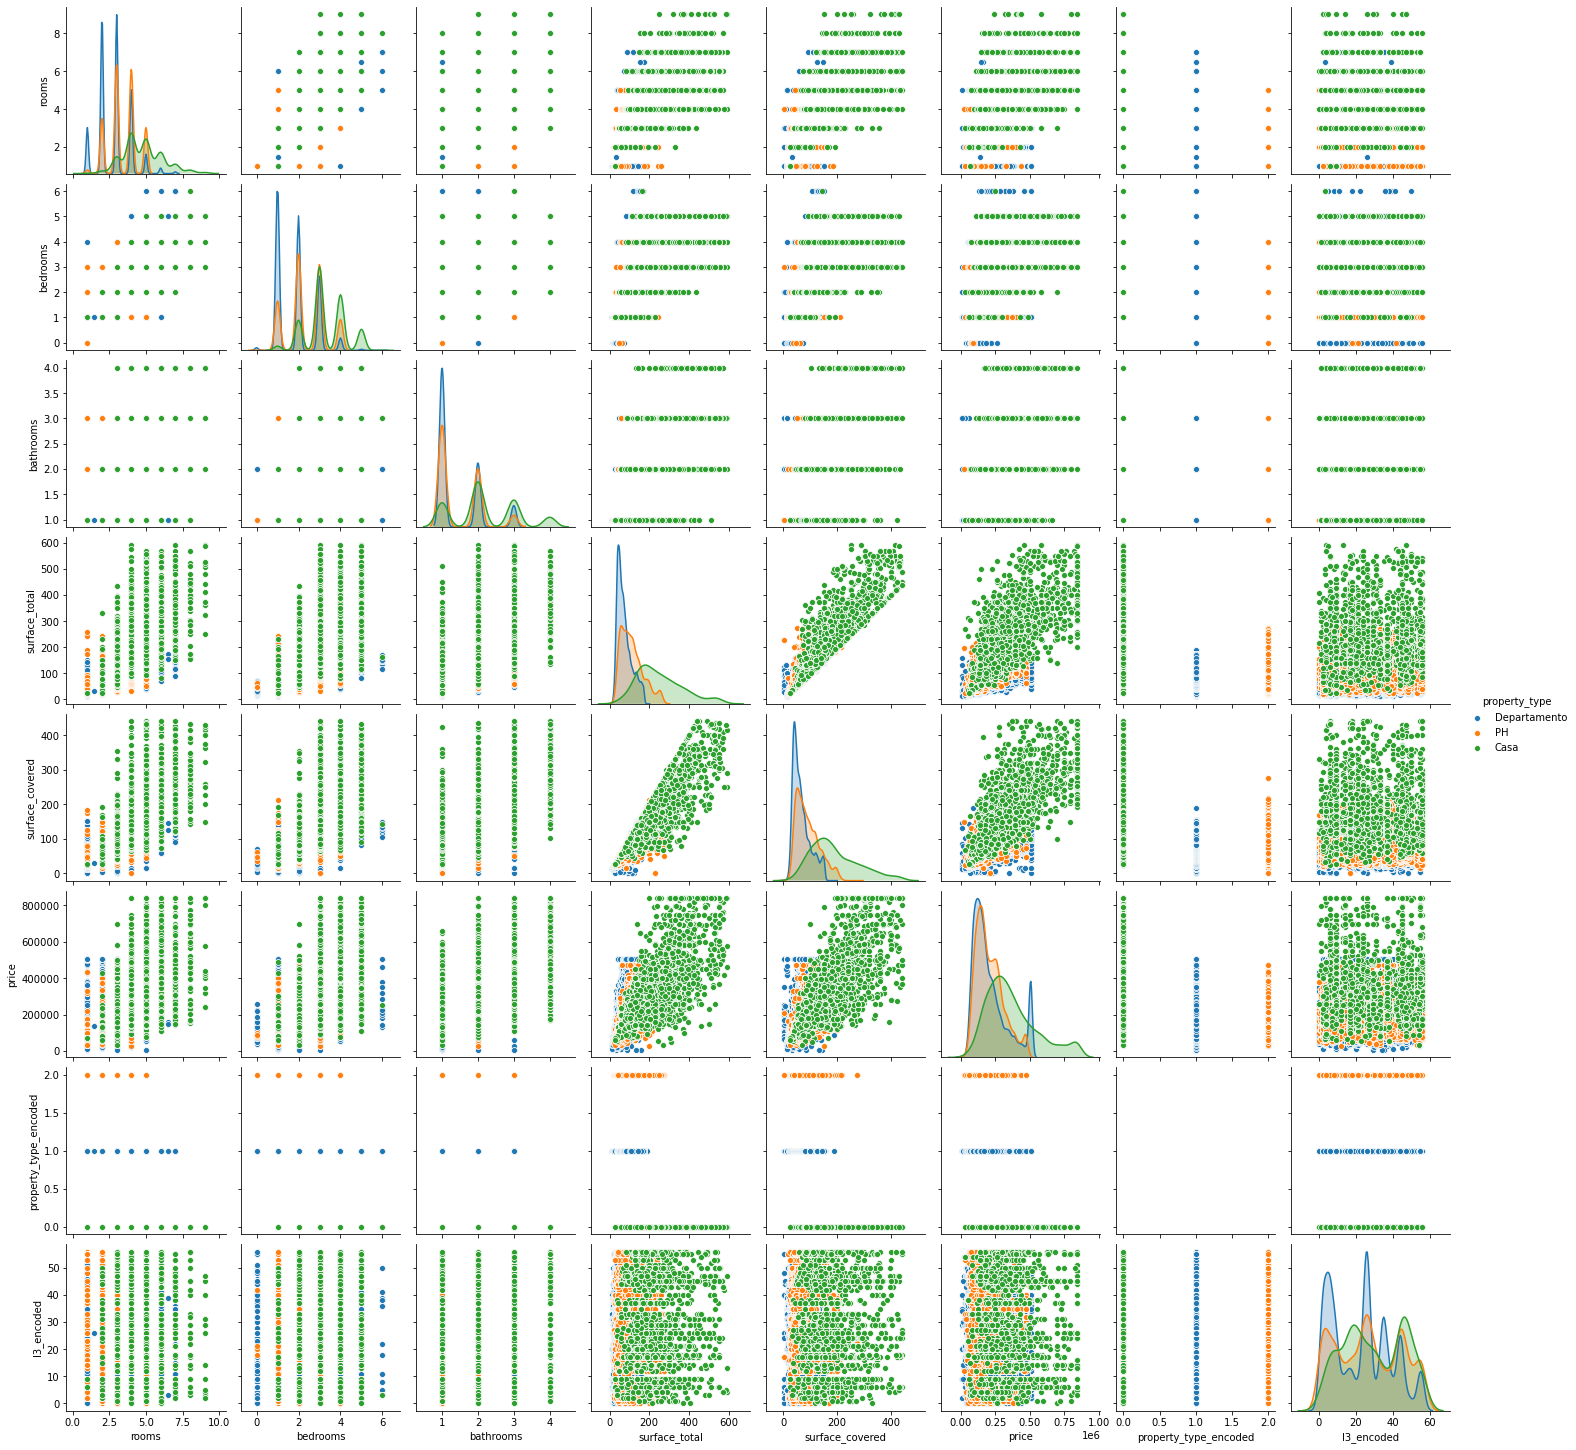

In [23]:
#graficar
sns.pairplot(df_encoded,hue='property_type')
plt.show()

Nueva forma de dataset. <b>NO EJECUTAR</b>. Tiene un mejor rendimiento pero el tiempo de carga es muy alto por las nuevas columnas hechas en el encoding.

Utilizando este dataset y RandomForest con 100 estimadores se consiguen los siguientes resultados

RMSE train:  16094.725967347276
RMSE test:  28489.00289966655

Aun que tarda demasiado en lograrlo

In [ ]:
#Nueva forma de dataset. NO EJECUTAR. Tiene un mejor rendimiento pero el tiempo de carga es muy alto por las nuevas columnas hechas en el encoding

data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

#Simplifico condiciones para poder aplicar distributiva booleana de forma más clara
condicion1 = (data['l2'].max())
condicion2 = (data['property_type'].value_counts()[:3].index.tolist()[0])
condicion3 = (data['property_type'].value_counts()[:3].index.tolist()[1])
condicion4 = (data['property_type'].value_counts()[:3].index.tolist()[2])

nuevadata = data[ (data['l2'] == condicion1) & ( (data['property_type'] == condicion2) | (data['property_type'] == condicion3) | (data['property_type'] == condicion4))]
#Creo nuevo dataframe en base a las nuevas instancias
nuevadata = pd.DataFrame(nuevadata)


nuevadata = calcular_iqr("surface_covered",nuevadata)
nuevadata = calcular_iqr("surface_total",nuevadata)
nuevadata = calcular_iqr("price",nuevadata)

#imprimo la forma
print (nuevadata.shape)

data_relevante = nuevadata[['l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','price','property_type']]
data_relevante = pd.DataFrame(data_relevante)

#encodig
data_encoded4 = pd.get_dummies(data_relevante, columns=["property_type", "l3"], prefix= ["tipo","barrio"])

data_encoded4 = data_encoded4.dropna()

data_encoded4
#NUEVO DATASET

## Utilizando datasets complementarios

Para complementar la información del dataset de Properati y agregar un pequeño desafío, utilicé un dataset que contiene todas las estaciones de SUBTE para calcular cuantas estaciones hay a una X distancia de las propiedades y así poder analizar si la cantidad de estaciones circundantes afectan el precio de las mismas.
<br> El dataset se puede conseguir en: <code> https://data.buenosaires.gob.ar/dataset/subte-estaciones </code>

In [32]:
# Buscamos saber cuantas estaciones de subte hay en un rango de 5 cuadras

estaciones_subte = pd.read_csv('estaciones-de-subte.csv')
#print(estaciones_subte.dtypes)

#funcion para calcular distancia en base a lat y long
from math import acos, cos, sin, radians

def medir_distancia(punto1,punto2):
    #Convierto los dos puntos en radianes para poder operar geometricamente
    punto1 = ( radians(punto1[0]), radians(punto1[1]) )
    punto2 = ( radians(punto2[0]), radians(punto2[1]) )
    
    #Obtengo al distancia cruda
    distancia = acos( sin(punto1[0]) * sin(punto2[0]) + cos(punto1[0]) * cos(punto2[0]) * cos(punto1[1]-punto2[1]) )
    
    #devuelvo el valor de distancia multiplicado por el radio de la tierra y multiplico por 1000 para sea en mts
    return (distancia * 6371)*1000

#funcion para saber cuantos subtes hay en un raido de 500 metros a la propiedad
def subte_cercanos(loc_prop):
    estaciones_cercanas=[]
    for estacion in estaciones_subte.itertuples():
        if( medir_distancia(loc_prop, (estacion[2], estacion[1])) < 500):
            estaciones_cercanas.append(estacion)
    return estaciones_cercanas



#estaciones_subte.head()
#print (medir_distancia((52.520016, 13.404971),(55.755824, 37.617287))/1000)

#lista_subtes = subte_cercanos((-34.618342, -58.401052))
#print(lista_subtes)

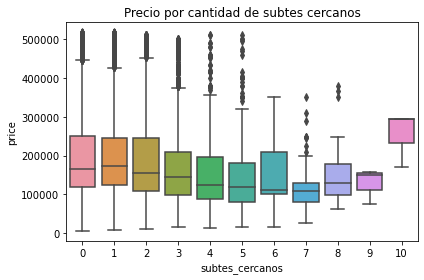

In [67]:
ds_prop_subte = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv') 
#boxplot subte y precio
data_test = calcular_iqr("price",ds_prop_subte[(ds_prop_subte['l2'] == 'Capital Federal')])
cantidad_subtes_propiedad =[]

for row in data_test.itertuples():
    cantidad_subtes_propiedad.append( len(subte_cercanos((row.lat, row.lon)) ))
#print(cantidad_subtes_propiedad)

data_test.insert(8, "subtes_cercanos", cantidad_subtes_propiedad, True) 
#data_test["subtes_cercanos"]=cantidad_subtes_propiedad

ax = sns.boxplot(data=data_test, x ="subtes_cercanos", y="price")
plt.title('Precio por cantidad de subtes cercanos')
plt.tight_layout()

## Desempeño del modelo anterior
Probamos uno de los modelos usados en el proyecto anterior con el nuevo data set y evaluamos su desempeño

In [34]:

df_model = df_encoded.copy()
#valores a usar en modelo para que sea similar al del proyecto anterior
y = df_model.price
df_model.drop(columns = {'price',"l3","property_type"}, inplace = True)
x = df_model

#train y tests split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 30)

#armo el modelo de decision tree
reg_knn = KNeighborsRegressor(n_neighbors = 17)

#entreno
reg_knn.fit(x_train,y_train)

#predigo
y_train_pred = reg_knn.predict(x_train)
y_test_pred = reg_knn.predict(x_test)



#evaluo desempeño
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("El desempeño que tiene el modelo anterior con el nuevo dataset es")
print('RMSE en Train:', rmse_train)
print('RMSE en Test:',rmse_test)

El desempeño que tiene el modelo anterior con el nuevo dataset es
RMSE en Train: 51969.55297143248
RMSE en Test: 56367.93473257136


Mientras que el modelo anterior con el dataset anterior tenia un resultado de RMSE en train de: 62389 y un RMSE en test de: 69781.
El desempeño mejoró un poco en comparación pero no de manera tan significativa en comparación con los nuevos modelos utilizados.

# Modelos avanzados

### Modelos de regresión

In [35]:
df_model = df_encoded.copy()
#valores a usar en modelo
y = df_model.price
df_model.drop(columns = {'price',"l3","property_type"}, inplace = True)
x = df_model
df_model

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_encoded,l3_encoded
0,7.0,4.0,2.0,140.0,140.0,1,38
1,2.0,1.0,2.0,70.0,58.0,2,8
2,2.0,1.0,1.0,45.0,45.0,2,26
3,2.0,1.0,1.0,85.0,50.0,2,26
5,2.0,1.0,1.0,56.0,56.0,2,44
...,...,...,...,...,...,...,...
146553,4.0,3.0,2.0,106.0,100.0,1,26
146554,4.0,3.0,3.0,175.0,111.0,2,26
146555,3.0,2.0,2.0,144.0,134.0,2,26
146556,4.0,2.0,2.0,200.0,143.0,2,26


In [36]:
#train y tests split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 30)

In [37]:
#modelo benchmark
y_pred_benchmark_train = np.repeat(y_train.mean(), y_train.size)
y_pred_benchmark_test = np.repeat(y_test.mean(), y_test.size)

rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_benchmark_train))
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred_benchmark_test))

In [38]:
#standar scaler
scaler = StandardScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
#Arbol clasificador
tree = DecisionTreeRegressor()

#grid search
param_grid = {'max_depth': np.arange(1,10),
             'min_samples_split': [5,10,15,20,25,30,40,45,50]}

model_tree = GridSearchCV(tree, param_grid=param_grid, cv=5)

#usamos la grilla para entrenar el modelo
model_tree.fit(x_train,y_train)

#predecimos
tree_y_pred_train = model_tree.predict(x_train)
tree_y_pred_test = model_tree.predict(x_test)

#rmse
tree_rmse_train = np.sqrt(mean_squared_error(y_train, tree_y_pred_train))
tree_rmse_test = np.sqrt(mean_squared_error(y_test, tree_y_pred_test))

In [40]:
#vecinos cercanos
knn =KNeighborsRegressor()

#grid search
param_grid = {'n_neighbors': np.arange(2,10)}

model_knn = GridSearchCV(knn, param_grid=param_grid,cv=5)

#entrenamos
model_knn.fit(x_train,y_train)



GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])})

In [41]:
knn_y_pred_train = model_knn.predict(x_train)
knn_y_pred_test = model_knn.predict(x_test)

#rmse
knn_rmse_train = np.sqrt(mean_squared_error(y_train, knn_y_pred_train))
knn_rmse_test = np.sqrt(mean_squared_error(y_test, knn_y_pred_test))

In [42]:
print('Benchmark')
print('RMSE train: ',rmse_train, ' |  RMSE test:', rmse_test)
print()

print('KNN')
print('RMSE train: ',knn_rmse_train, ' |  RMSE test:', knn_rmse_test)
print('Mejores parametros elegidos: '+ str(model_knn.best_params_) )
print('Score: '+ str(model_knn.best_score_))
print()

print('Arbol de decisión')
print('RMSE train: ',tree_rmse_train, ' |  RMSE test:', tree_rmse_test)
print('Mejores parametros elegidos: '+ str(model_tree.best_params_) )
print('Score: '+ str(model_tree.best_score_))

Benchmark
RMSE train:  125568.13109807183  |  RMSE test: 126468.1672174499

KNN
RMSE train:  34100.2746981544  |  RMSE test: 49047.538020761356
Mejores parametros elegidos: {'n_neighbors': 3}
Score: 0.8459122418693357

Arbol de decisión
RMSE train:  54672.889695930935  |  RMSE test: 57357.96420273114
Mejores parametros elegidos: {'max_depth': 9, 'min_samples_split': 10}
Score: 0.788916891524271


# Parte B - Modelos avanzados
#### Pruebo los nuevos modelos que vimos para evaluar su resultado en comparación con los recien vistos

In [43]:
lista_de_modelos = []
N_modelos = 20

In [44]:
#train y tests split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state = 67)
#Después de pruebas los modelos funcionan mejor con una muestra 0.10

In [45]:
for i in range(N_modelos):
    X_train_boostrap, _, y_train_boostrap, _ = train_test_split(x_train, y_train, test_size=0.5)
    reg = DecisionTreeRegressor(max_depth = None) #lo dejamos overfitear
    reg.fit(X_train_boostrap, y_train_boostrap)
    lista_de_modelos.append(reg)

In [46]:
for idx, modelo in enumerate(lista_de_modelos):
    y_test_pred = modelo.predict(x_test)
    #rmse
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print('RMSE del modelo ', idx, ' es ', rmse_test)
    

RMSE del modelo  0  es  52991.94926573618
RMSE del modelo  1  es  53102.965542638245
RMSE del modelo  2  es  52935.769234799795
RMSE del modelo  3  es  53073.99974937484
RMSE del modelo  4  es  54629.35116909364
RMSE del modelo  5  es  53149.4219282702
RMSE del modelo  6  es  52798.167636755425
RMSE del modelo  7  es  54601.25471557097
RMSE del modelo  8  es  53351.500875657715
RMSE del modelo  9  es  54760.21704828713
RMSE del modelo  10  es  53187.73440942031
RMSE del modelo  11  es  54215.761851611205
RMSE del modelo  12  es  53036.57941150636
RMSE del modelo  13  es  55400.16330810818
RMSE del modelo  14  es  52793.824856416315
RMSE del modelo  15  es  54486.78807852764
RMSE del modelo  16  es  54773.15940496982
RMSE del modelo  17  es  52925.15131308406
RMSE del modelo  18  es  52768.37968976002
RMSE del modelo  19  es  52547.33418535169


### Random forest

In [47]:
train_rmse = []
test_rmse = []

N_estimadores = [1,2,3,4,5,10,25,50,100,250,500,1000]
for estimadores in N_estimadores:
    print(estimadores)
    reg = RandomForestRegressor(n_estimators=estimadores, n_jobs=-1, random_state = 42)
    reg.fit(x_train,y_train)
    
    y_train_pred = reg.predict(x_train)
    y_test_pred = reg.predict(x_test)
    
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
train_rmse = np.array(train_rmse)
test_rmse = np.array(test_rmse)


1
2
3
4
5
10
25
50
100
250
500
1000


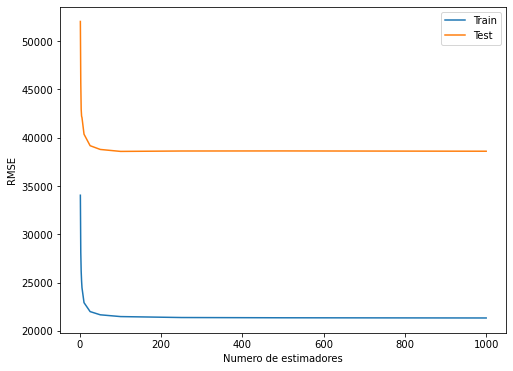

In [48]:
plt.figure(figsize = (8,6))
plt.plot(N_estimadores, train_rmse, label = 'Train')
plt.plot(N_estimadores, test_rmse, label = 'Test')
plt.xlabel('Numero de estimadores')
plt.ylabel('RMSE')
plt.legend()
plt.show()


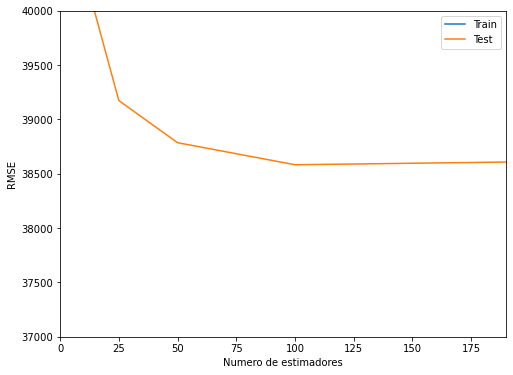

Mejor resultado:  38582.51582772934  con  100 estimadores


In [49]:
plt.figure(figsize = (8,6))
plt.plot(N_estimadores, train_rmse, label = 'Train')
plt.plot(N_estimadores, test_rmse, label = 'Test')
plt.xlabel('Numero de estimadores')
plt.ylabel('RMSE')
plt.legend()
plt.xlim(0,190)
plt.ylim(37000,40000)
plt.show()

mejor_estimador = N_estimadores[list(test_rmse).index(test_rmse.min())]
print("Mejor resultado: ",test_rmse.min(), " con ",mejor_estimador , "estimadores")

### Generamos el modelo con los datos observados


In [50]:
regressor = RandomForestRegressor(n_estimators=mejor_estimador, n_jobs=-1, random_state = 42)

regressor.fit(x_train, y_train)   

y_pred_test = regressor.predict(x_test)
y_pred_train = regressor.predict(x_train)


print("RMSE train: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

print("RMSE test: ",np.sqrt(mean_squared_error(y_test, y_pred_test)))




RMSE train:  21475.47135957702
RMSE test:  38582.51582772934


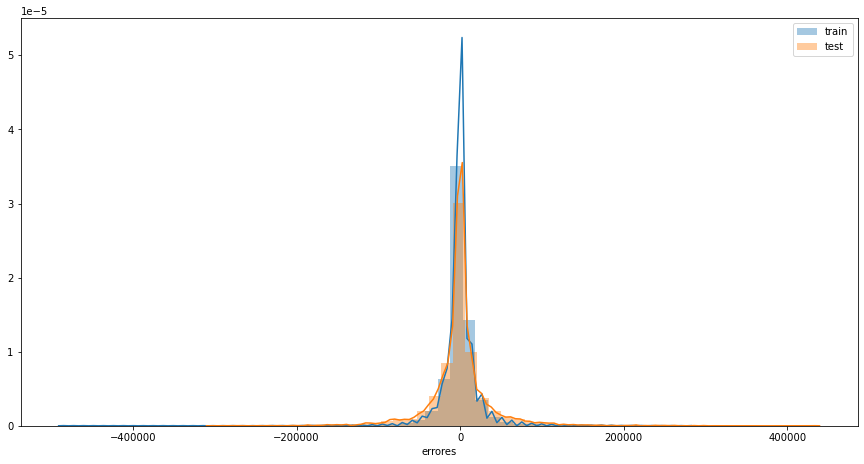

In [51]:
#grafico
plt.figure(figsize = (15,7.5))

sns.distplot(y_train - y_pred_train, hist=True, label = 'train')
sns.distplot(y_test - y_pred_test, hist=True, label = 'test')
plt.xlabel('errores')
plt.legend()

En el grafico se puede ver que la mayoría de los errores se encuentran en -10.000 y + 10.000 y tiene una distribucion leptocurtica ya que los datos estan agrupados en intervalos "estrechos" haciendo que haya una disperción relativamente pequeña pero elevada.

### Relevancia de variable del dataset
Analizamos la importancia que el modelo seleccionado le da a cada feature con la función que el mismo modelo brinda

In [52]:
importancia = regressor.feature_importances_

for i in range(len(df_model.columns)):
    print('La importancia que el algoritmo da al feature' ,df_model.columns[i], 'es:', importancia[i] )

La importancia que el algoritmo da al feature rooms es: 0.015257638546217832
La importancia que el algoritmo da al feature bedrooms es: 0.012886181229371725
La importancia que el algoritmo da al feature bathrooms es: 0.0391182674434897
La importancia que el algoritmo da al feature surface_total es: 0.17186451957635462
La importancia que el algoritmo da al feature surface_covered es: 0.601854040282204
La importancia que el algoritmo da al feature property_type_encoded es: 0.03819909662201655
La importancia que el algoritmo da al feature l3_encoded es: 0.12082025630034554


Los datos más importantes a tener en cuenta al momento de predecir el valor de una propiedad segun lo observado en los modelos utilizados son los metros cuadrados de la propiedad y el barrio en donde se ubica.

#### Probamos el mismo modelo utilizando CV

In [53]:
scores = cross_val_score(regressor, x, y, cv=6)
print ("Cross-validated scores:", scores)

Cross-validated scores: [0.89741535 0.91617711 0.89426381 0.89395462 0.8911021  0.92450146]


In [54]:
predictions = cross_val_predict(regressor, x, y, cv=6)

Accuracy obtendio:  0.9034350532273895


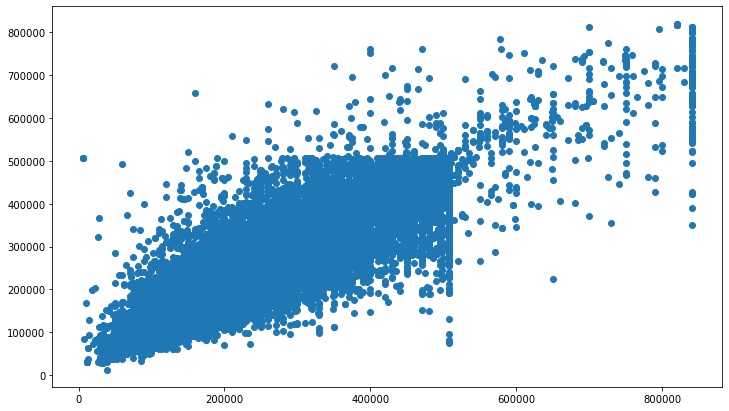

In [55]:
plt.figure(figsize=(12, 7))
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Accuracy obtendio: ",accuracy)

In [56]:
print("Rmse :", np.sqrt(mean_squared_error(y, predictions)))

Rmse : 39104.29254881067


Dado que los resultados de usar Cross Validation en el modelo no presentan una mejora sustancial en el resultado, se recomienda optar por obviarlo ya que es menos carga computacional.

### Boosting

In [57]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [58]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20), n_estimators=150)
ada_reg.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=150)

In [59]:
y_train_pred = ada_reg.predict(x_train)
y_test_pred = ada_reg.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))


67995.03173465419
61187.735251024445


Text(0.5, 0, 'Número de árbol')

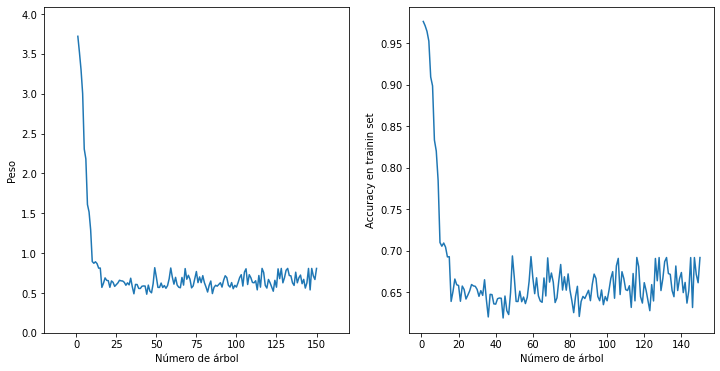

In [60]:
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada_reg)

# En la variable estimator_weights_ esta el peso de cada arbol
pesos = ada_reg.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En estimator_errors_ esta el error que comete cada uno.
errores_arboles = ada_reg.estimator_errors_[:numero_arboles]
accuracy_arboles = 1-errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

## Conclusión

Por lo observado en las prueba hechas en los modelos llego a la conclusión de que lo mejor sería utilizar un modelo de RandomForestRegressor con un estimador de 100. Como <code>regressor</code>.

Seguir entrenando el modelo sería un gasto de recursos ya que no hay una mejoría considerable.
Queda mucho por mejorar ya que el error sigue siendo relativamente alto pero presenta mejoras en comparación con el modelo del proyecto anterior, bajando el rmse de más de 100.000 a 49.000. Personalmente mejoraría la exploración y limpieza de datos.

Los datos más importantes a tener en cuenta al momento de predecir el valor de una propiedad segun lo observado en los modelos utilizados son los metros cuadrados de la propiedad y el barrio en donde se ubica.
